In [33]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os

import numpy as np

import plotly.express as px

In [34]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
df = pd.read_csv('/Users/jmmill29/Desktop/heart.csv')

In [36]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [37]:
# Feature and label transformations

df_features = df.drop(['target'], axis = 1)
df_labels = df.loc[:, 'target']

# Get one-hot columns for nominal variables to pass to neural net classifier

new_cols = pd.concat([pd.get_dummies(df_features.loc[:, 'sex'], dtype = float, prefix='sex'),
            pd.get_dummies(df_features.loc[:, 'cp'], dtype = float, prefix='cp'),
            pd.get_dummies(df_features.loc[:, 'fbs'], dtype = float, prefix='fbs'),
            pd.get_dummies(df_features.loc[:, 'restecg'], dtype = float, prefix='restecg'),
            pd.get_dummies(df_features.loc[:, 'exang'], dtype = float, prefix='exang'),
            pd.get_dummies(df_features.loc[:, 'thal'], dtype = float, prefix = 'thal')], axis = 1)

df_features_dummies = pd.concat([df_features, new_cols], axis = 1).drop(['sex', 'cp', 'fbs',
                                                                            'restecg', 'exang', 'thal'], axis = 1)

In [38]:
df_features_dummies

,age,trestbps,chol,thalach,oldpeak,slope,ca,sex_0,sex_1,cp_0,...,fbs_1,restecg_0,restecg_1,restecg_2,exang_0,exang_1,thal_0,thal_1,thal_2,thal_3
0,52,125,212,168,1.0,2,2,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,53,140,203,155,3.1,0,0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,70,145,174,125,2.6,0,0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,61,148,203,161,0.0,2,1,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,62,138,294,106,1.9,1,3,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,140,221,164,0.0,2,0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1021,60,125,258,141,2.8,1,1,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1022,47,110,275,118,1.0,1,1,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1023,50,110,254,159,0.0,2,0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [39]:
# Check for balance in class representation

df_labels.value_counts()

target
1    526
0    499
Name: count, dtype: int64

In [40]:
# Standard neural net classifier. We will use the modern and numerically stable nn.BCEWithLogitsLoss which
# applies the sigmoid internally and therefore the final output of our net is a single neuron
# without sigmoid 

class Classifier(nn.Module):

    def __init__(self, input_dim):
        super(Classifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(input_dim, input_dim *4),
            nn.ReLU(),
            nn.Linear(input_dim * 4, input_dim *8),
            nn.ReLU(),
            nn.Linear(input_dim*8, input_dim *4),
            nn.ReLU(),
            nn.Linear(input_dim *4 , input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim //2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim // 4),
            nn.ReLU(),
            nn.Linear(input_dim // 4, 1)

        )

    def forward(self, x):
        return self.classifier(x)

In [41]:
# A standard VAE class which we will use to test classification
# after latent encoding without simultaneous optimization of the latent encoding 

class VAE(nn.Module):

    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        
        # Input tensor size B x input_dim
        # Output tensor size B x latent_dim * 2
        # Output is mean and diagonal covariance matrix entries for Gaussian in latent space ( R^{latent_dim} )

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, latent_dim * 4),
            nn.ReLU(),
            nn.Linear(latent_dim * 4 , latent_dim * 8),
            nn.ReLU(),
            nn.Linear(latent_dim * 8 , latent_dim * 16),
            nn.ReLU(),
            nn.Linear(latent_dim * 16 , latent_dim * 8),
            nn.ReLU(),
            nn.Linear(latent_dim * 8 , latent_dim * 4),
            nn.ReLU(),
            nn.Linear(latent_dim * 4 , latent_dim * 2),
        )


        # Input tensor size B x latent_dim
        # Output tensor size B x input_dim * 2
        # Output is mean and diagonal precision matrix (stability) entries for Gaussian in input space ( R^{input_dim} )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_dim * 4),
            nn.ReLU(),
            nn.Linear(input_dim * 4 , input_dim * 8),
            nn.ReLU(),
            nn.Linear(input_dim * 8 , input_dim * 16),
            nn.ReLU(),
            nn.Linear(input_dim * 16 , input_dim * 8),
            nn.ReLU(),
            nn.Linear(input_dim * 8 , input_dim * 4),
            nn.ReLU(),
            nn.Linear(input_dim * 4 , input_dim * 2),
        )

        self.softplus = nn.Softplus()


      
    
    def encode(self, x, eps: float = 1e-8):

        # Get parameter vectors for latent Gaussian, ensure positive definite entries for covariance, embed entries in matrix
        # return distribution object, mean, log variance  

        z_params = self.encoder(x)
        mu, logvar = torch.chunk(z_params, 2, dim = -1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
    
    
        return [torch.distributions.MultivariateNormal(mu, scale_tril = scale_tril), mu, logvar]


      
    
    def reparam(self, dist):

        # Use built-in Pytorch reparameterization trick functionality to sample from distribution object  


        return dist.rsample()


    def decode(self, z):

        # Get mean and log precision for input space from latent representation

        x_params = self.decoder(z)
        mu, logprec = torch.chunk(x_params, 2, dim = -1)
        

        return [mu, logprec]


    def forward(self, x):

        # Get latent space parameter vectors, sample from latent space using these vectors, get reconstructed input parameter
        # vectors from latent space sample, return all vectors

        z_dist, z_mu, z_logvar = self.encode(x)
        z = self.reparam(z_dist)
        x_mu, x_logprec = self.decode(z)


        return [x_mu, x_logprec, z_mu, z_logvar] 



    def loss_function(self, x, params, prior_scale,
                                        recon_penalty,
                                        kld_penalty): 
                                        
                                        # prior_scale is float to constrain the Guassian prior over latent space
                                        # recon_penalty constrains the recon_loss
                                        # kld_penalty constrains the kld loss

        # Minimize the negative elbo (reconstruction score + KL Divergence between Gaussion prior and posterior
        # over latent sapce)

        x_mu, x_logprec, z_mu, z_logvar = params

        l = x - x_mu
        l2 = l**2

        recon_loss = torch.mean(0.5 * torch.sum(x_logprec.exp() * l2 - x_logprec  , dim = 1), dim = 0)
        scale = z_mu ** 2 + z_logvar.exp()
        scale = prior_scale * scale
        kld = torch.sum(1 + z_logvar - scale, dim = 1)
        kld =  - np.log(prior_scale) + kld
        kld = torch.mean(- 0.5 * kld, dim = 0)


        return recon_penalty * recon_loss +  kld_penalty * kld   

     
    def test_reconstruction_loss(self, x):

        # Get reconstruction scores for input tensor. Input is tensor of size N x input_dim where
        # N is the size of either train or test set. Output is tensor of size N. Average over 10
        # reconstruction samples to obtain stable estimate

       x_mu, x_logprec, z_mu, z_logvar = self.forward(x)

       l = x - x_mu
       l2 = l**2

       recon_loss = 0.5 * torch.sum(x_logprec.exp() * l2 - x_logprec  , dim = 1)

       for i in range(0,9):
              x_mu, x_logprec, z_mu, z_logvar = self.forward(x)

              l = x - x_mu
              l2 = l**2

              recon_loss_2 = 0.5 * torch.sum(x_logprec.exp() * l2 - x_logprec  , dim = 1)
              recon_loss = recon_loss + recon_loss_2

       
       return recon_loss/10

    
    def reconstruct(x, model):

        # Reconstruct a given input tensor according to the generative model and return its associated
        # reconstruction score 
        
        z_dist, z_mu, z_logvar = model.encode(x)
        z = z_dist.sample()
        x_mu, x_logprec = model.decode(z)

        x_prec = torch.diag_embed(x_logprec.exp())
        x = torch.distributions.MultivariateNormal(x_mu, precision_matrix= x_prec).sample()

        l = x - x_mu
        l2 = l**2

        recon_loss = 0.5 * torch.sum(x_logprec.exp() * l2 - x_logprec, dim = 1)


        return [x, recon_loss]



In [42]:
# An encoder/classifier pair which first encodes features into latent space
# and then classifies based upon the expected value of the encoding. 
# We use a 10 sample Monte Carlo estimate for the expected value of the latent sample
# Encoder parameters here are optimized simultaneous to the classifier

class Latent_classifier(nn.Module):

    def __init__(self, input_dim, latent_dim):
        super(Latent_classifier, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, latent_dim * 4),
            nn.ReLU(),
            nn.Linear(latent_dim * 4 , latent_dim * 8),
            nn.ReLU(),
            nn.Linear(latent_dim * 8 , latent_dim * 16),
            nn.ReLU(),
            nn.Linear(latent_dim * 16 , latent_dim * 8),
            nn.ReLU(),
            nn.Linear(latent_dim * 8 , latent_dim * 4),
            nn.ReLU(),
            nn.Linear(latent_dim * 4 , latent_dim * 2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, latent_dim *4),
            nn.ReLU(),
            nn.Linear(latent_dim * 4, latent_dim *8),
            nn.ReLU(),
            nn.Linear(latent_dim*8, latent_dim *4),
            nn.ReLU(),
            nn.Linear(latent_dim *4 , latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim //2),
            nn.ReLU(),
            nn.Linear(latent_dim // 2, latent_dim // 4),
            nn.ReLU(),
            nn.Linear(latent_dim // 4, 1)
        )

        self.softplus = nn.Softplus()


    def encode(self, x, eps: float = 1e-8):

        # Get parameter vectors for latent Gaussian, ensure positive definite entries for covariance, embed entries in matrix
        # return distribution object, mean, log variance  

        z_params = self.encoder(x)
        mu, logvar = torch.chunk(z_params, 2, dim = -1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
    
    
        return [torch.distributions.MultivariateNormal(mu, scale_tril = scale_tril), mu, logvar]

    
    def reparam(self, dist):

        # Use built-in Pytorch reparameterization trick functionality to sample from distribution object  


        return dist.rsample()

    
    def forward(self, x):
        sample = self.reparam(self.encode(x)[0])
        for i in range(0,9):
            sample += self.reparam(self.encode(x)[0])
        latent = sample/10
    
        return self.classifier(latent)

In [68]:
def make_train_test_split(features, labels, split):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = split)
    mean = X_train.mean()
    std = np.sqrt(X_train.var())
    X_train = ( X_train - mean ) / std
    X_test = ( X_test - mean ) / std

    X_train_tensor = torch.Tensor(np.array(X_train))
    y_train_tensor = torch.Tensor(np.array(y_train)).reshape(-1,1) #BCEWithLogits requires 2d tensor for labels 
    X_test_tensor = torch.Tensor(np.array(X_test))
    y_test_tensor = torch.Tensor(np.array(y_test))

    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor



In [44]:
# Define the training pipeline for the classifier
# This pipeline will be used on both the raw feature classifier
# as well as the latent space classifier

def classifier_train(model, optimizer, epochs, loss_fn, train_dl):
    loss_hist_train = [0] * epochs 
    for epoch in range(epochs):
        for x,y in train_dl:
            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits,y)
            loss.backward()
            optimizer.step() 
            loss_hist_train[epoch] += loss.item()
        print(epoch)
        print(loss_hist_train[epoch])

    return loss_hist_train

In [45]:
# Standard VAE training pipeline to optimize ELBO

def vae_train(model, optimizer, train_dl, epochs, prior_scale, recon_penalty, kld_penalty):
    loss_hist_train = [0] * epochs 
    for epoch in range(epochs):
        for data in train_dl:
            optimizer.zero_grad()
            params = model(data)
            loss = model.loss_function(data, params, prior_scale, recon_penalty, kld_penalty)
            loss.backward()
            optimizer.step() 
            loss_hist_train[epoch] += loss.item()
        print(epoch)
        print(loss_hist_train[epoch])

    return loss_hist_train

In [46]:
# Return the accuracy of a given classifier on the test set

def test_accuracy(X_test_tensor, y_test_tensor, classifier):
    logits = classifier(X_test_tensor)
    sigmoid = nn.Sigmoid()
    probs = sigmoid(logits)
    probs = torch.flatten(probs)
    correct = (probs > .5).float() == y_test_tensor
    total = torch.sum(correct.float())
    accuracy = total/y_test_tensor.shape[0]
    return accuracy

0
13.974564790725708
1
11.900356620550156
2
10.28564265370369
3
8.881175473332405
4
8.788148149847984
5
9.321836024522781
6
7.756823495030403
7
6.520965866744518
8
6.588602781295776
9
5.391037710011005
10
4.552582293748856
11
3.4899413399398327
12
4.6084202248603106
13
3.253935366868973
14
3.22573116235435
15
2.943098470568657
16
2.457154456526041
17
0.9680596313555725
18
0.7349234165158123
19
0.4346602722653188
20
3.143554340573246
21
3.0584936337545514
22
1.6963015859946609
23
2.4831766271963716
24
0.6949747541802935
25
2.107116684608627
26
2.671984809450805
27
0.9160626830998808
28
0.2867624331283878
29
0.225708534293517
30
0.4354255265233178
31
0.05199530748359393
32
0.010734856167346152
33
0.004427218020168766
34
0.0028647627464124525
35
0.002140650187357096
36
0.0016192727935049334
37
0.0013544015399133968
38
0.0011358534218288696
39
0.000948199442746045
40
0.0008334922979180703
41
0.0006973360462270151
42
0.0006186863822748023
43
0.000548193243616879
44
0.0004932735182592296
45


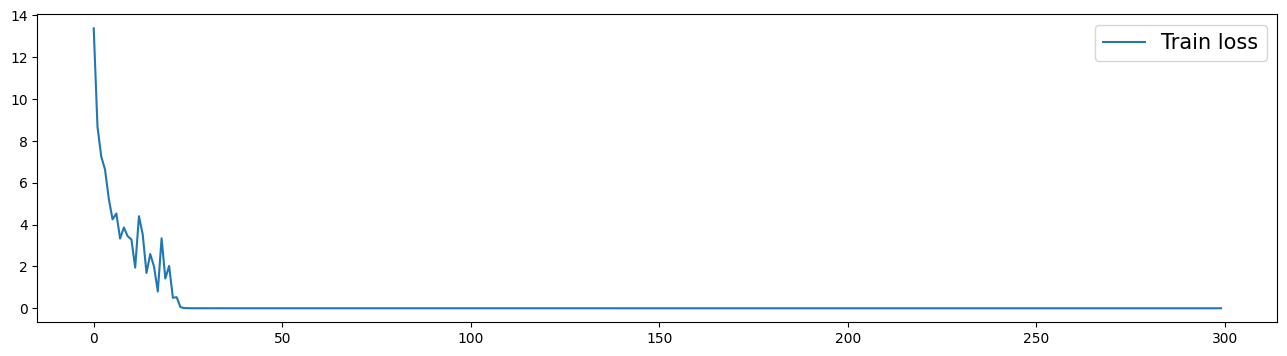

In [75]:
# Perform k-fold cross validation on the raw feature classifier

k_fold = 5
batch_size = 32
loss_fn = nn.BCEWithLogitsLoss()

accuracy = 0

for i in range(0,k_fold):

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = make_train_test_split(df_features_dummies, df_labels, 0.2)

# Initialize and train the raw feature classifier


    raw_classifier = Classifier( input_dim = X_train_tensor.shape[1] )
    raw_classifier_optimizer = torch.optim.Adam(raw_classifier.parameters(), lr=0.01)
    train_ds_raw_classifier = TensorDataset(X_train_tensor, y_train_tensor)
    train_dl_raw_classifier = DataLoader(train_ds_raw_classifier, batch_size, shuffle=True)

    history_raw_classifier = classifier_train(model = raw_classifier, 
                            optimizer = raw_classifier_optimizer, 
                            epochs=300, 
                            train_dl = train_dl_raw_classifier,
                            loss_fn = loss_fn)

    accuracy += test_accuracy(X_test_tensor, y_test_tensor, raw_classifier).item()
accuracy /= k_fold

fig = plt.figure(figsize=(16, 4)) 
plt.plot(history_raw_classifier)
plt.legend(['Train loss'], fontsize=15)
print('Accuracy:', accuracy)




In [72]:
# Train latent space classifier with ascending settings for dimension of latent space representation
# to test the dimension onto which we can project the features in latent space while maintaining high
# accuracy

batch_size_latent = 64
loss_fn = nn.BCEWithLogitsLoss()

# We use a slightly smaller k_fold for computation time but 
# can increase if a more accurate measurement is needed

k_fold = 3
accuracy_dims = [0] * 5

for i in range(2,7):
    for k in range(0,k_fold):

        X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = make_train_test_split(df_features_dummies, df_labels, 0.2)

        latent_classifier = Latent_classifier(input_dim = X_train_tensor.shape[1], latent_dim = i * 5)
        latent_classifier_optimizer = torch.optim.Adam(latent_classifier.parameters(), lr=0.001)
        train_ds_latent_classifier = TensorDataset(X_train_tensor, y_train_tensor)
        train_dl_latent_classifier = DataLoader(train_ds_latent_classifier, batch_size_latent, shuffle=True)

        history_latent_classifier = classifier_train(model=latent_classifier, 
                            optimizer=latent_classifier_optimizer, 
                            epochs=200, 
                            train_dl = train_dl_latent_classifier,
                            loss_fn = loss_fn)

        accuracy_dims[i-2] += test_accuracy(X_test_tensor, y_test_tensor, latent_classifier).item()
    accuracy_dims[i-2] /= k_fold
    
print('Accuracy 10 dim:', accuracy_dims[0])
print('Accuracy 15 dim:', accuracy_dims[1])
print('Accuracy 20 dim:', accuracy_dims[2])
print('Accuracy 25 dim:', accuracy_dims[3])
print('Accuracy 30 dim:', accuracy_dims[4])



0
9.975775003433228
1
9.862426280975342
2
9.749956488609314
3
9.681485652923584
4
9.665020883083344
5
9.574641346931458
6
9.510010302066803
7
9.474238097667694
8
9.291118204593658
9
8.38689535856247
10
8.059000253677368
11
7.873046666383743
12
7.6433369517326355
13
7.495048701763153
14
7.351175516843796
15
7.216688334941864
16
7.139272481203079
17
7.011164367198944
18
6.893051505088806
19
6.793307423591614
20
6.69739493727684
21
6.654668360948563
22
6.707297712564468
23
6.56140524148941
24
6.378838151693344
25
6.30847954750061
26
6.302550494670868
27
6.204991012811661
28
6.138161212205887
29
6.101349383592606
30
6.060632646083832
31
6.157394468784332
32
6.161484628915787
33
6.052524894475937
34
5.959709316492081
35
5.911206394433975
36
5.927438408136368
37
5.956962049007416
38
5.934038490056992
39
5.889651834964752
40
5.687963783740997
41
5.6413673758506775
42
5.5904281437397
43
5.576712667942047
44
5.53380686044693
45
5.494988262653351
46
5.45827579498291
47
5.438883036375046
48
5.416

0
313.98258781433105
1
314.44627475738525
2
312.2298002243042
3
312.65102767944336
4
311.4757947921753
5
311.8355178833008
6
311.9100170135498
7
311.2040376663208
8
313.0949659347534
9
311.6665382385254
10
313.5630769729614
11
311.2006902694702
12
312.0116777420044
13
311.5933303833008
14
313.1975984573364
15
311.1742420196533
16
312.2567596435547
17
311.31510734558105
18
312.3145332336426
19
311.767409324646
20
311.52412605285645
21
310.7054080963135
22
310.6152763366699
23
308.67998027801514
24
305.70295810699463
25
294.8557653427124
26
269.97760820388794
27
276.365026473999
28
242.08374786376953
29
205.01688289642334
30
196.74039936065674
31
190.5260853767395
32
168.20013189315796
33
152.76960849761963
34
171.07819032669067
35
141.87654042243958
36
155.25994491577148
37
144.92140245437622
38
128.93430829048157
39
121.84181034564972
40
109.43118333816528
41
94.19375693798065
42
152.5417593717575
43
168.63809084892273
44
143.65095233917236
45
118.13764691352844
46
98.8159568309784
47


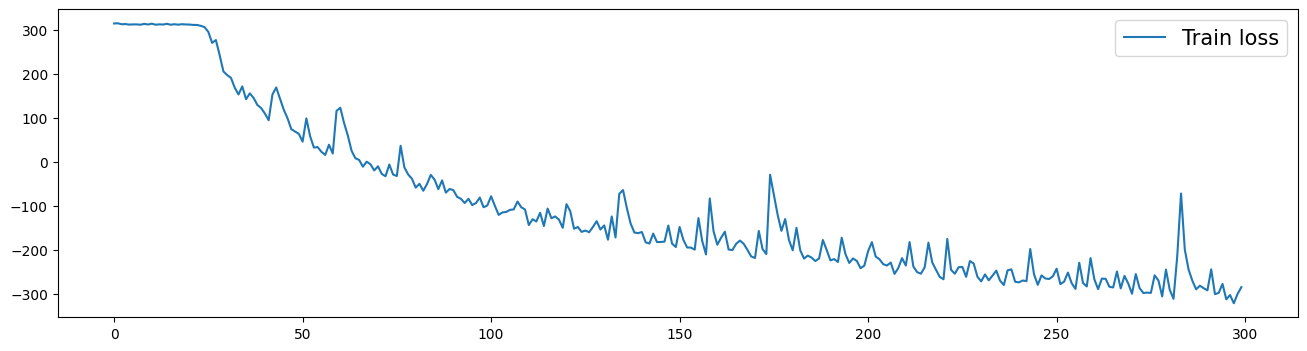

In [76]:
# Define and train the variational autoencoder
# We use the smallest dimension latent representation which maintained high classification
# accuracy 

latent_model = VAE(input_dim = X_train_tensor.shape[1] , latent_dim = 20)
latent_model_optimizer = torch.optim.AdamW(latent_model.parameters(), lr = 1e-4)
train_dl_latent_model = DataLoader(X_train_tensor, batch_size, shuffle = True)

history_vae = vae_train(model=latent_model, 
                        optimizer=latent_model_optimizer, 
                        train_dl = train_dl_latent_model,
                        epochs=300, 
                        prior_scale=1,
                        recon_penalty=1,
                        kld_penalty=1)

fig = plt.figure(figsize=(16, 4)) 
plt.plot(history_vae)
plt.legend(['Train loss'], fontsize=15)



0
9.291528284549713
1
9.244975209236145
2
9.225603997707367
3
9.21044397354126
4
9.205873131752014
5
9.189521372318268
6
9.17635840177536
7
9.173542439937592
8
9.156072556972504
9
9.136111080646515
10
9.077292442321777
11
8.940073490142822
12
8.719550132751465
13
8.513347744941711
14
8.206562995910645
15
7.918297350406647
16
7.851396441459656
17
7.604212164878845
18
7.397249400615692
19
7.144053518772125
20
6.997791945934296
21
6.71970209479332
22
6.43553426861763
23
6.284310430288315
24
6.173621833324432
25
6.08177575469017
26
5.988891631364822
27
5.945607572793961
28
5.9376333355903625
29
5.803147375583649
30
5.719459772109985
31
5.669172614812851
32
5.6662560403347015
33
5.66452893614769
34
5.565105617046356
35
5.518580824136734
36
5.411657810211182
37
5.310067653656006
38
5.25929468870163
39
5.205780595541
40
5.186939626932144
41
5.15120393037796
42
5.106856286525726
43
5.079743683338165
44
5.050932586193085
45
5.032791793346405
46
5.010943382978439
47
4.95647069811821
48
4.9431824

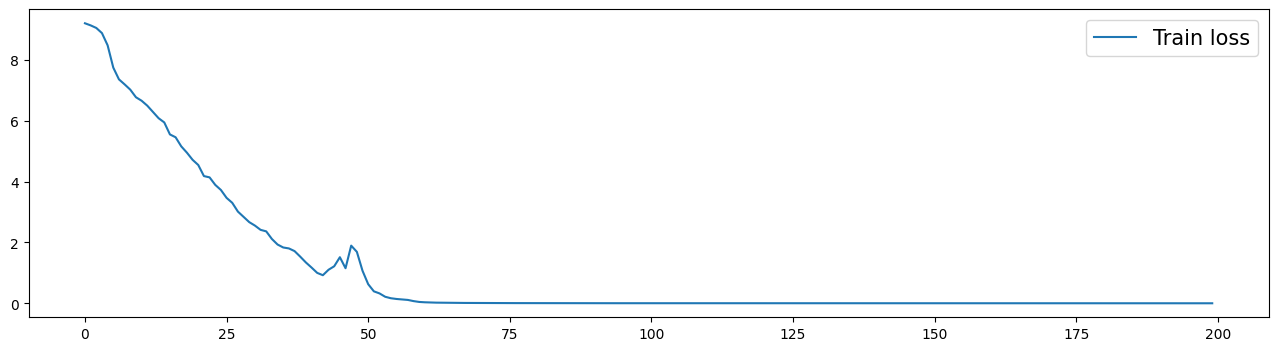

In [77]:
# Transform the features according to the latent space representation learned by the autoencoder without simultaneous
# optimization, retrain classifier on transformed features and test accuracy

batch_size = 64
k_fold = 5
accuracy = 0
for i in range (0,k_fold):

    latent_train = pd.DataFrame(latent_model.reparam(latent_model.encode(X_train_tensor)[0]).detach().numpy())
    latent_test = pd.DataFrame(latent_model.reparam(latent_model.encode(X_test_tensor)[0]).detach().numpy())

    mean = latent_train.mean()
    std = np.sqrt(latent_train.var())
    latent_train = ( latent_train - mean ) / std
    latent_test = ( latent_test - mean ) / std

    latent_train_tensor = torch.Tensor(np.array(latent_train))
    latent_test_tensor = torch.Tensor(np.array(latent_test))

    latent_classifier_indiv = Classifier(input_dim=latent_train_tensor.shape[1])
    optimizer_latent_classifier_indiv = torch.optim.Adam(latent_classifier_indiv.parameters(), lr=0.001)

    train_ds_latent_classifier_indiv = TensorDataset(latent_train_tensor, y_train_tensor)
    train_dl_latent_classifier_indiv = DataLoader(train_ds_latent_classifier_indiv, batch_size, shuffle=True)
    history_latent_classifier_indiv = classifier_train(model=latent_classifier_indiv, 
                            optimizer=optimizer_latent_classifier_indiv, 
                            epochs=200, 
                            train_dl = train_dl_latent_classifier_indiv,
                            loss_fn = loss_fn)
    accuracy += test_accuracy(latent_test_tensor, y_test_tensor, latent_classifier_indiv).item()
accuracy /= k_fold

fig = plt.figure(figsize=(16, 4)) 
plt.plot(history_latent_classifier_indiv)
plt.legend(['Train loss'], fontsize=15)

print('Accuracy w/o simultaneous optimization:', accuracy)